Big Data And Society: Lab 3
=====


# Data Scraping

### 0. Importing the library

First we need to import the libraries, and some of their components. We will be using **Twython**, a library that provides wrappers around Twitter's API. To install **Twython** on a terminal or the command line, run the following command:
```
pip install twython
```

We also need to create a Python file that will contain the **Twitter** keys. It is never a good idea to host these keys on a public website like **github**, so one way to keep them private is importing the keys as a variable from a separate, untracked file. If you haven’t done so, at this point you should obtain your twitter API keys. Create a python file on the same directory of your **IPython** notebook, and name it: **`twitter_key.py`**.

```
# In the file you should define two variables:
t_key = ‘your twitter key’
t_secret = ‘your twitter secret’
```

Get your Twitter key and secret code on the [Twitter Apps site](https://apps.twitter.com/). You will need to create an application, it doesn't matter what you call it, to get your key and secret code. Once your application is created, you will find your keys on the **Keys and Access Tokens** tab of your application.

In [4]:
import json
import time
import threading

from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import t_key, t_secret


### 1. Query the Twitter API
Now we are going to construct a **Twython** object; this object simplifies the access to the [Twitter API](https://dev.twitter.com/overview/documentation), and provides methods for accessing the API’s endpoints. The first function fetches tweets with a given query at a given lat-long. We will be using the search parameters to hit the APIs endpoint. We need to provide the lat/lon of the centroid of the area we want to query, maximum number of tweets to return, and area within the centroid to search for, among others. 

Additional documentation of the Twython API can be found [here]( https://twython.readthedocs.org/en/latest/)


In [5]:
# Assigns the keys to the variables
APP_KEY = t_key
APP_SECRET = t_secret

# Setup a Lat Lon
latlong = [24.6333, 46.7167]

''' Fetches tweets with a given query at a given lat-long.'''
def get_tweets( latlong=None ):
    # Creates a Twithon object with the given keys
    twitter = Twython( APP_KEY, APP_SECRET )
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = twitter.search( geocode=','.join([ str(x) for x in latlong ]) + ',15km', result_type='recent', count=10000)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

### 2. Hit the API and Parse the Result
We are going to create a function to help us repeatedly hit the API, and parse the result into a readable JSON that contains the things that we are interested in, and still stores the raw tweet as an additional property. The returned object is a Python `dict` that we can easily parse into another dictionary to later store as a JSON. Raw JSONs returned from the API have a specific structure. It can be sometimes hard to read a raw JSON. I find it easy to use some online parses like [this]( http://json.parser.online.fr/) to look at the structure of the JSON, and only access what we care about. 


In [26]:
""" Does pretty much what its long name suggests. """
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 120
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 30 
    while remaining_seconds > 0:
        added = 0
        # We hit the Twitter API
        new_tweets = get_tweets( latlong )
        # We parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets and tweet['coordinates'] != None:
                properties = {}
                properties['lat'] = tweet['coordinates']['coordinates'][1]
                properties['lon'] = tweet['coordinates']['coordinates'][0]
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['user_location'] = tweet['user']['location']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print "At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets ) )
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    # We return the final dictionary
    return all_tweets

### 3. Run the Functions

We need to call the functions, and save the JSONs into a location. In this case, I made a folder called `twitter`, where I a m saving all the new JSONS. We can run the code continuously utilizing some loop, or we can use libraries like `threading`. 


In [27]:
'''This function executes the rest of the functions over a given period of time'''
def run():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            # We define a centroid in Riyadh
            latlong = [24.6333, 46.7167]
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( '%stweets.json' %(timestr), 'w' ) as f:
                f.write( json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run()

At 0 seconds, added 86 new tweets, for a total of 86
At 30 seconds, added 1 new tweets, for a total of 87
At 60 seconds, added 0 new tweets, for a total of 87
At 90 seconds, added 1 new tweets, for a total of 88


### 4. Parse the JSONs
Once we have collected some data, we can parse it, and visualize some of the results. Since some of the data is repeated, we can initialize some lists to check whether or not a tweet already exists, and add it to the list. We can then extract the useful information for our purposes, and store it in another list.


In [29]:
# Import additional libraries
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get the file names from a given directory
file_dir = '/Users/mrcampbell/Documents/github/16_11.S947/week4/tweets' # Set this to where your JSON saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# Initialize some lists to store the points, and the ids of the tweets
ids = []
all_pts = []
# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file)
    # Open the JSON
    with open(full_dir) as f:
        data = f.read()
        # Load the JSON as a dict
        dict = json.loads(data)
        # Only add the unique tweets to the list
        if not isinstance(dict, list):
            for key, val in dict.iteritems():
                if key not in ids:
                    ids.append(key)
                    lat = val['lat']
                    lon = val['lon']
                    all_pts.append([lat,lon])
pts = np.array(all_pts)
pts                

array([[ 24.61417794,  46.65241895],
       [ 24.72549681,  46.76798234],
       [ 24.75013687,  46.62406983],
       [ 24.71517   ,  46.69749   ],
       [ 24.67166667,  46.67472222],
       [ 24.6934341 ,  46.6912101 ],
       [ 24.67843804,  46.80088653],
       [ 24.75703539,  46.74516572],
       [ 24.70794414,  46.77567521],
       [ 24.67843804,  46.80088653],
       [ 24.72519352,  46.85316218],
       [ 24.72530632,  46.85314812],
       [ 24.65660055,  46.62753248],
       [ 24.50772999,  46.61781644],
       [ 24.64798538,  46.68509938],
       [ 24.64732   ,  46.71458   ],
       [ 24.5901696 ,  46.6315801 ],
       [ 24.6934341 ,  46.6912101 ],
       [ 24.58747424,  46.58643588],
       [ 24.7135517 ,  46.6752957 ],
       [ 24.65669736,  46.7397922 ],
       [ 24.7388077 ,  46.8860302 ],
       [ 24.7452123 ,  46.5771542 ],
       [ 24.5970165 ,  46.6170261 ],
       [ 24.6911786 ,  46.68376786],
       [ 24.5463087 ,  46.6533035 ],
       [ 24.64798303,  46.68519956],
 

### 5. Plot some Tweets
We can use **matplotlib** to visualize some tweets.

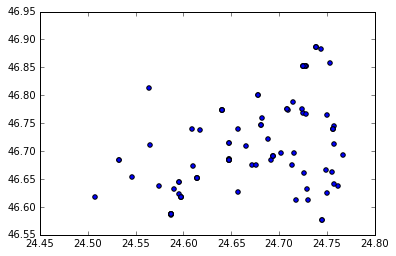

In [32]:
# Use a scatter plot to make a quick visualization of the data points
plt.scatter(pts[:,0], pts[:,1])

Lets make sure that we don't get tweets plotted more than once. How would you make sure to only plot unique tweets? We can maybe:

* Construct a list with unique id's
* Only add the tweets to the `numpy.array` if the tweet doesn't exist in the list.

### Problem Set - Extend What you Learned

Now that you know how to scrape data let's extend the exercise a little so you can show us what you know. This time you will set up the scraper to get data around MIT and scrap data for 15 minutes and visualize. Think about what you would need to change to do that. 

Once you have the new json file of Boston tweets you should make a new array so that you can make a new scatter plot of your Boston tweets. When you make this new array you should get at least two different attributes returned by the Twitter api. One of them should be the tweet id. Make sure you remove and duplicate tweets (if any). Plot the tweets with different colors (use lat/long to determine the colors) using the scatter plot tool. Then save the data to a CSV.

Make sure you get your own Twitter Key.

#### Deliverables

**1** - Collect Tweets from Boston for 15 min. Note how you set the time in the above example, it was in seconds. How would you do that here? 

**2** - Plot your tweets using matplotlib.

**3** - Change colors based on lat/long position.

**4** - Save your array CSV file. We will be checking this CSV file for duplicates. So clean your file.  

### What to Give Us on Stellar 

1 - Iphython notebook of your scrapper, which includes your scattterplot.

2 - Your final CSV file. 

### Bonus # 1

Bonus  -- Do the orginally planned assignment now titled Bonus. If you do the whole thing you get a free homework assignment. If  you do parts of it you will get points to future assignments. 
